In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn import set_config; set_config(display='diagram')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectFromModel, mutual_info_classif

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Importing Data

In [2]:
from src.getdata_utils import load_and_split_data
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data()

# Data Cleaning

In [3]:
from src.training_utils import CyclicalMonthEncoder

CyclicalMonthEncoder()

,column_name,'month'


In [4]:
from src.training_utils import build_preprocessor, fit_and_return_preprocessed_df, transform_with_feature_names

# 5. Build the preprocessor based on training data
preprocessor = build_preprocessor(X_train)

# 6. Fit and transform X_train
X_train_df, preprocessor, feature_names = fit_and_return_preprocessed_df(preprocessor, X_train)

# 7. Transform validation and test sets using the same fitted preprocessor
X_val_df = transform_with_feature_names(preprocessor, X_val, feature_names)
X_test_df = transform_with_feature_names(preprocessor, X_test, feature_names)

# Logistic Regression

In [5]:
# Define each model pipeline
logreg_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state= 42))
])


In [6]:
logreg_pipeline

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical_features', ...), ('num_transformer', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [7]:
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt

def evaluate_model(y_true, y_pred, y_proba=None, beta=1.0, average='binary', plot_roc=False):
    """
    Evaluates a classification model with various metrics.

    Parameters:
        y_true (array-like): True target values
        y_pred (array-like): Predicted labels
        y_proba (array-like): Predicted probabilities (for ROC-AUC). Required if plot_roc=True or for roc_auc_score.
        beta (float): Weight of recall in the F-beta score. beta < 1 gives more weight to precision.
        average (str): Scoring method for multi-class problems. Use 'binary', 'macro', 'micro', or 'weighted'
        plot_roc (bool): Whether to plot the ROC curve

    Returns:
        dict: Dictionary of evaluation metrics
    """
    results = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average=average, zero_division=0),
        'Recall': recall_score(y_true, y_pred, average=average, zero_division=0),
        'F1 Score': f1_score(y_true, y_pred, average=average),
        f'F{beta}-Score': fbeta_score(y_true, y_pred, beta=beta, average=average)
    }

    if y_proba is not None:
        try:
            roc_auc = roc_auc_score(y_true, y_proba)
            results['ROC AUC'] = roc_auc
            if plot_roc:
                fpr, tpr, _ = roc_curve(y_true, y_proba)
                plt.figure()
                plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
                plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.title("ROC Curve")
                plt.legend()
                plt.grid(True)
                plt.show()
        except:
            results['ROC AUC'] = 'Error: Cannot compute ROC AUC'

    return results

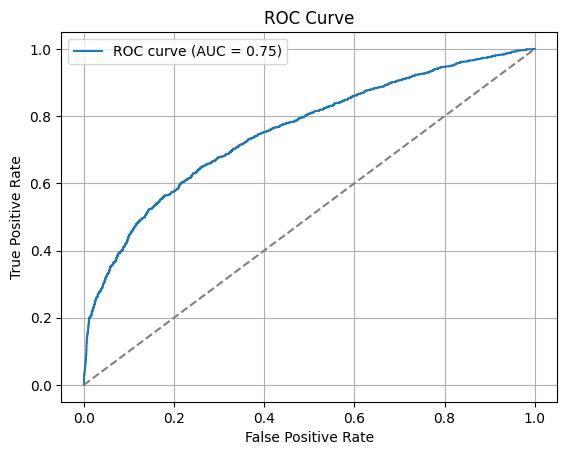

Accuracy: 0.8943817739438178
Balanced Accuracy: 0.5810639473654303
Precision: 0.6973180076628352
Recall: 0.1720226843100189
F1 Score: 0.2759666413949962
F0.5-Score: 0.4329210275927688
ROC AUC: 0.7545174233154399


In [8]:
# Fit your model
logreg_pipeline.fit(X_train, y_train)

# Predict class labels
y_pred = logreg_pipeline.predict(X_val)

# Predict probabilities for ROC-AUC
y_proba = logreg_pipeline.predict_proba(X_val)[:, 1]

# Evaluate
metrics = evaluate_model(y_val, y_pred, y_proba=y_proba, beta=0.5, plot_roc=True)
for metric, value in metrics.items():
    print(f"{metric}: {value}")


# Baseline Model
## Always predic the majority class

In [9]:
# Let's say y_val contains the true values
y_baseline = np.zeros_like(y_val)  # predict "0" for all (no investment)

# Evaluate it
baseline_results = {
    "Accuracy": accuracy_score(y_val, y_baseline),
    "Precision": precision_score(y_val, y_baseline, zero_division=0),
    "Recall": recall_score(y_val, y_baseline),
    "F1 Score": f1_score(y_val, y_baseline),
    "ROC AUC": roc_auc_score(y_val, y_baseline) if len(np.unique(y_val)) == 2 else "N/A"
}

for metric, value in baseline_results.items():
    print(f"{metric}: {value}")

Accuracy: 0.8829904888299049
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.5


In [10]:
# I am testing again with the newly installed packages
# pip install nbdime
# nbdime config-git --enable
